# Setup 

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip -q install ultralytics timm
import ultralytics
ultralytics.checks()

import os, cv2, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.cluster import KMeans
from collections import Counter, defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6586.4/8062.4 GB disk)
Device: cuda | torch 2.6.0+cu124


In [3]:
!pip install roboflow
from roboflow import Roboflow
%pip install ultralytics supervision roboflow

rf = Roboflow(api_key="kb3t7HveaF3ISN0TEWpk")
project = rf.workspace("palm-oil-vj5ii").project("dat-palm-fx-vfhm6")
version = project.version(1)
dataset = version.download("coco")

print("Downloaded dataset to:", dataset.location)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.3


Extracting Dataset Version Zip to Dat-Palm-Fx-1 in coco:: 100%|██████████| 4810/4810 [00:01<00:00, 2935.25it/s]


Downloaded dataset to: /kaggle/working/Dat-Palm-Fx-1


In [4]:
from pathlib import Path
import torch

BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
WORK.mkdir(parents=True, exist_ok=True)
LABELED_ROOT = WORK / "yolo_labeled"          
DATA_LABELED = LABELED_ROOT / "data.yaml"     
UNLABELED_IMGS = WORK / "unlabeled_images"    
PSEUDO_ROOT   = WORK / "pseudo_labels"       
DATA_SSL      = WORK / "data_soft_teacher_ssl.yaml"
STUDENT_CFG   = "yolov12n.yaml"
TEACHER_WEIGHTS_INIT = "yolov12s.pt"         
TEACHER_WEIGHTS_TR   = WORK / "teacher_yolov12n_trained.pt"
STUDENT_WEIGHTS_TR   = WORK / "student_yolov12n_soft_teacher.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device              :", device)
print("WORK                :", WORK)
print("LABELED_ROOT        :", LABELED_ROOT)
print("DATA_LABELED        :", DATA_LABELED)
print("UNLABELED_IMGS      :", UNLABELED_IMGS)
print("PSEUDO_ROOT         :", PSEUDO_ROOT)
print("DATA_SSL (student)  :", DATA_SSL)
print("TEACHER_INIT_WEIGHTS:", TEACHER_WEIGHTS_INIT)
print("TEACHER_WEIGHTS_TR  :", TEACHER_WEIGHTS_TR)
print("STUDENT_CFG         :", STUDENT_CFG)
print("STUDENT_WEIGHTS_TR  :", STUDENT_WEIGHTS_TR)


Device              : cuda
WORK                : /kaggle/working/palm_soft_teacher_yolov12n
LABELED_ROOT        : /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
DATA_LABELED        : /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled/data.yaml
UNLABELED_IMGS      : /kaggle/working/palm_soft_teacher_yolov12n/unlabeled_images
PSEUDO_ROOT         : /kaggle/working/palm_soft_teacher_yolov12n/pseudo_labels
DATA_SSL (student)  : /kaggle/working/palm_soft_teacher_yolov12n/data_soft_teacher_ssl.yaml
TEACHER_INIT_WEIGHTS: yolov12s.pt
TEACHER_WEIGHTS_TR  : /kaggle/working/palm_soft_teacher_yolov12n/teacher_yolov12n_trained.pt
STUDENT_CFG         : yolov12n.yaml
STUDENT_WEIGHTS_TR  : /kaggle/working/palm_soft_teacher_yolov12n/student_yolov12n_soft_teacher.pt


# Converting COCO → YOLO 

In [5]:
from pathlib import Path
import json, shutil, yaml


BASE        = Path("/kaggle/working")
DATASET_DIR = BASE / "Dat-Palm-Fx-1"

# New workspace for Soft-Teacher 
WORK         = BASE / "palm_soft_teacher_yolov12n"
LABELED_ROOT = WORK / "yolo_labeled"    
SPLIT        = LABELED_ROOT               
DATA_LABELED = LABELED_ROOT / "data.yaml" 

WORK.mkdir(parents=True, exist_ok=True)

print("BASE        :", BASE)
print("DATASET_DIR :", DATASET_DIR)
print("WORK        :", WORK)
print("LABELED_ROOT:", LABELED_ROOT)
print("DATA_LABELED:", DATA_LABELED)


def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw/2) / w, (y + bh/2) / h, bw / w, bh / h


train_ann_path = DATASET_DIR / "train" / "_annotations.coco.json"
if not train_ann_path.exists():
    raise FileNotFoundError(f"Train annotation file not found: {train_ann_path}")

train_coco = json.load(open(train_ann_path, "r"))
all_categories = sorted(train_coco.get("categories", []), key=lambda x: x["id"])
present_cat_ids = set(a["category_id"] for a in train_coco.get("annotations", []))


categories = [c for c in all_categories if c["id"] in present_cat_ids]


empty_cats = [c for c in all_categories if c["id"] not in present_cat_ids]
if empty_cats:
    print("The following categories exist in 'categories' but have zero instances in train annotations:")
    for c in empty_cats:
        print(f"   id={c['id']}\tname={c['name']}")
    print("They will be excluded from the YOLO mapping (nc will decrease).")

# Create mapping: 
id2new = {cat["id"]: i for i, cat in enumerate(categories)}
print("Using category mapping (original id -> new index):")
for orig, new in id2new.items():
    print(f"   {orig} -> {new}")


def convert(split_name, img_dir, ann_json_path):
    out_im = SPLIT / split_name / "images"
    out_lb = SPLIT / split_name / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    ann_json_path = Path(ann_json_path)
    if not ann_json_path.exists():
        raise FileNotFoundError(f"Annotations file not found: {ann_json_path}")

    coco = json.load(open(ann_json_path, "r"))
    # build image id -> info map
    id2img = {
        im["id"]: {
            k: im[k] for k in ("id", "file_name", "width", "height")
        }
        for im in coco["images"]
    }

    skipped_annotations = 0
    for ann in coco["annotations"]:
        orig_cat = ann["category_id"]
        if orig_cat not in id2new:
            
            skipped_annotations += 1
            continue

        img = id2img[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = id2new[orig_cat]

        lbl_path = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(lbl_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    if skipped_annotations:
        print(f"Skipped {skipped_annotations} annotations because their category_id is not in the train mapping.")

    # copy images
    img_dir = Path(img_dir)
    missing = 0
    for im in coco["images"]:
        src = img_dir / im["file_name"]
        if src.exists():
            shutil.copy(src, out_im / im["file_name"])
        else:
            missing += 1

    if missing:
        print(f"{missing} image files missing from {img_dir} (referenced in annotations but not found).")


if SPLIT.exists():
    shutil.rmtree(SPLIT)
    print("Old labeled YOLO split removed:", SPLIT)

print("➤ Converting COCO → YOLO (labeled set) …")
convert("train", DATASET_DIR / "train", DATASET_DIR / "train" / "_annotations.coco.json")
convert("valid", DATASET_DIR / "valid", DATASET_DIR / "valid" / "_annotations.coco.json")
convert("test",  DATASET_DIR / "test",  DATASET_DIR / "test"  / "_annotations.coco.json")


names = [c["name"] for c in categories]
LABELED_ROOT.mkdir(parents=True, exist_ok=True)
DATA_LABELED.write_text(yaml.dump({
    "path": str(LABELED_ROOT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(names),
    "names": names
}, sort_keys=False))

print("✓ Labeled YOLO dataset ready at", LABELED_ROOT)
print("  data.yaml:", DATA_LABELED)
print("classes (nc):", len(names), names)


BASE        : /kaggle/working
DATASET_DIR : /kaggle/working/Dat-Palm-Fx-1
WORK        : /kaggle/working/palm_soft_teacher_yolov12n
LABELED_ROOT: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
DATA_LABELED: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled/data.yaml
The following categories exist in 'categories' but have zero instances in train annotations:
   id=0	name=palms-obj
They will be excluded from the YOLO mapping (nc will decrease).
Using category mapping (original id -> new index):
   1 -> 0
   2 -> 1
   3 -> 2
➤ Converting COCO → YOLO (labeled set) …
✓ Labeled YOLO dataset ready at /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
  data.yaml: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled/data.yaml
classes (nc): 3 ['abnormal_palm', 'dead_palm', 'healthy_palm']


# Class Distribution

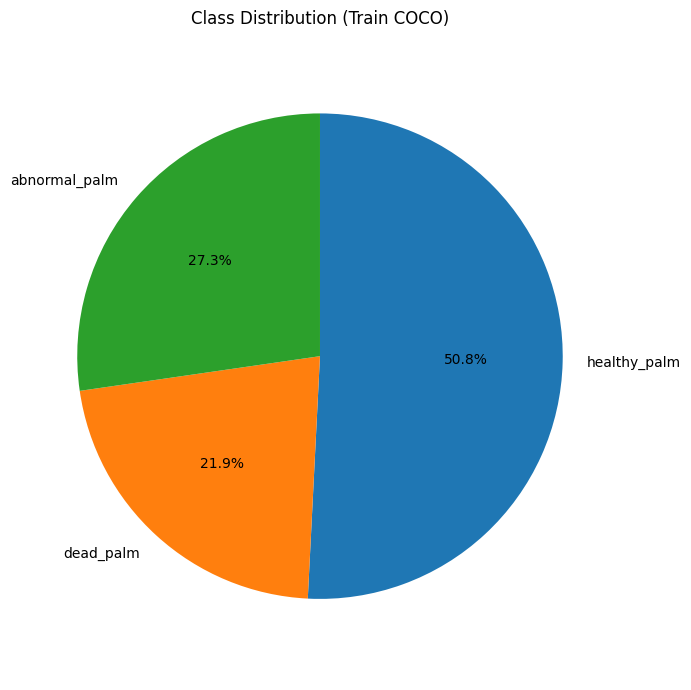

In [6]:
train_ann_path = DATASET_DIR / "train" / "_annotations.coco.json"
with open(train_ann_path, "r") as f:
    coco_train = json.load(f)

# category_id -> name
id_to_name = {c["id"]: c["name"] for c in coco_train["categories"]}

# count instances per category_id
cnt = Counter(ann["category_id"] for ann in coco_train["annotations"])

labels = [id_to_name[cid] for cid in cnt.keys()]
values = [cnt[cid] for cid in cnt.keys()]

plt.figure(figsize=(7, 7))
plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
plt.title("Class Distribution (Train COCO)")
plt.axis("equal")  
plt.tight_layout()
plt.show()


## Soft Teacher–Style YOLOv12s

In [7]:
from pathlib import Path
import json, shutil, yaml, random


BASE        = Path("/kaggle/working")

# Root of your COCO dataset from Roboflow
DATASET_DIR = BASE / "Dat-Palm-Fx-1"

# Workspace for Soft-Teacher YOLOv12n
WORK         = BASE / "palm_soft_teacher_yolov12n"
LABELED_ROOT = WORK / "yolo_labeled"     
SPLIT        = LABELED_ROOT               
DATA_LABELED = LABELED_ROOT / "data.yaml" 

WORK.mkdir(parents=True, exist_ok=True)

print("BASE        :", BASE)
print("DATASET_DIR :", DATASET_DIR)
print("WORK        :", WORK)
print("LABELED_ROOT:", LABELED_ROOT)
print("DATA_LABELED:", DATA_LABELED)


def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw/2) / w, (y + bh/2) / h, bw / w, bh / h


train_ann_path = DATASET_DIR / "train" / "_annotations.coco.json"
if not train_ann_path.exists():
    raise FileNotFoundError(f"Train annotation file not found: {train_ann_path}")

train_coco = json.load(open(train_ann_path, "r"))
all_categories = sorted(train_coco.get("categories", []), key=lambda x: x["id"])
present_cat_ids = set(a["category_id"] for a in train_coco.get("annotations", []))


categories = [c for c in all_categories if c["id"] in present_cat_ids]


empty_cats = [c for c in all_categories if c["id"] not in present_cat_ids]
if empty_cats:
    print("The following categories exist in 'categories' but have zero instances in train annotations:")
    for c in empty_cats:
        print(f"   id={c['id']}\tname={c['name']}")
    print("They will be excluded from the YOLO mapping (nc will decrease).")

# mapping: original category_id -> continuous 0..nc-1
id2new = {cat["id"]: i for i, cat in enumerate(categories)}
print("Using category mapping (original id -> new index):")
for orig, new in id2new.items():
    print(f"   {orig} -> {new}")


# Conversion function: COCO JSON → YOLO txt + copied images

def convert(split_name, img_dir, ann_json_path):
    out_im = SPLIT / split_name / "images"
    out_lb = SPLIT / split_name / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    ann_json_path = Path(ann_json_path)
    if not ann_json_path.exists():
        raise FileNotFoundError(f"Annotations file not found: {ann_json_path}")

    coco = json.load(open(ann_json_path, "r"))
    # image id -> info
    id2img = {
        im["id"]: {
            k: im[k] for k in ("id", "file_name", "width", "height")
        }
        for im in coco["images"]
    }

    skipped_annotations = 0
    for ann in coco["annotations"]:
        orig_cat = ann["category_id"]
        if orig_cat not in id2new:
            skipped_annotations += 1
            continue

        img = id2img[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = id2new[orig_cat]

        lbl_path = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(lbl_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    if skipped_annotations:
        print(f"Skipped {skipped_annotations} annotations because their category_id is not in the train mapping.")

    # copy images
    img_dir = Path(img_dir)
    missing = 0
    for im in coco["images"]:
        src = img_dir / im["file_name"]
        if src.exists():
            shutil.copy(src, out_im / im["file_name"])
        else:
            missing += 1

    if missing:
        print(f"{missing} image files missing from {img_dir} (referenced in annotations but not found).")

#  run conversion 

if SPLIT.exists():
    shutil.rmtree(SPLIT)
    print("Old labeled YOLO split removed:", SPLIT)

print("➤ Converting COCO → YOLO (full labeled dataset) …")
convert("train", DATASET_DIR / "train", DATASET_DIR / "train" / "_annotations.coco.json")
convert("valid", DATASET_DIR / "valid", DATASET_DIR / "valid" / "_annotations.coco.json")
convert("test",  DATASET_DIR / "test",  DATASET_DIR / "test"  / "_annotations.coco.json")

# write canonical data.yaml
names = [c["name"] for c in categories]
LABELED_ROOT.mkdir(parents=True, exist_ok=True)
DATA_LABELED.write_text(yaml.dump({
    "path": str(LABELED_ROOT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(names),
    "names": names
}, sort_keys=False))

print("✓ Labeled YOLO dataset ready at", LABELED_ROOT)
print("  data.yaml:", DATA_LABELED)
print("classes (nc):", len(names), names)


# 2) Build 80/10/10 split and 20% labeled / 80% unlabeled
SSL_ROOT = WORK / "ssl_80_10_10"
if SSL_ROOT.exists():
    shutil.rmtree(SSL_ROOT)
    print("Old SSL split removed:", SSL_ROOT)
SSL_ROOT.mkdir(parents=True, exist_ok=True)

train_imgs_src   = LABELED_ROOT / "train" / "images"
train_labels_src = LABELED_ROOT / "train" / "labels"

# collect all image stems
img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
    img_paths.extend(train_imgs_src.glob(ext))
img_paths = sorted(img_paths)

if not img_paths:
    raise RuntimeError(f"No training images found in {train_imgs_src}")

stems = [p.stem for p in img_paths]

random.seed(42)
random.shuffle(stems)

n_total = len(stems)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val  # rest

train_pool_stems = stems[:n_train]
val_stems        = stems[n_train:n_train + n_val]
test_stems       = stems[n_train + n_val:]

def copy_pair(stem_list, split_name, labeled=True):
    dst_im = SSL_ROOT / split_name / "images"
    dst_lb = SSL_ROOT / split_name / "labels"
    dst_im.mkdir(parents=True, exist_ok=True)
    if labeled:
        dst_lb.mkdir(parents=True, exist_ok=True)

    for s in stem_list:
        # image
        src_im = None
        for ext in (".jpg", ".jpeg", ".png", ".bmp"):
            cand = train_imgs_src / f"{s}{ext}"
            if cand.exists():
                src_im = cand
                break
        if src_im is None:
            print(f"[WARN] image not found for stem {s}")
            continue

        shutil.copy(src_im, dst_im / src_im.name)

        # label
        if labeled:
            src_lb = train_labels_src / f"{s}.txt"
            if src_lb.exists():
                shutil.copy(src_lb, dst_lb / src_lb.name)
            else:
                print(f"[WARN] label not found for stem {s}")

# val/test: always fully labeled
copy_pair(val_stems,  "val",  labeled=True)
copy_pair(test_stems, "test", labeled=True)

#20% labeled / 80% unlabeled within TRAIN 
random.shuffle(train_pool_stems)
n_labeled = max(1, int(0.2 * len(train_pool_stems)))

# NEW variable names 
train_labeled_imgs   = train_pool_stems[:n_labeled]
train_unlabeled_imgs = train_pool_stems[n_labeled:]

# labeled part: images + labels
copy_pair(train_labeled_imgs, "train_labeled", labeled=True)

# unlabeled part
copy_pair(train_unlabeled_imgs, "train_unlabeled", labeled=False)

#  prints in your requested format 
print("Total images:")
print(f"Train pool: {len(train_pool_stems)}, Val: {len(val_stems)}, Test: {len(test_stems)}")
print(f"Labeled train: {len(train_labeled_imgs)}, Unlabeled train: {len(train_unlabeled_imgs)}")

# data.yaml for TEACHER (uses only 20% labeled subset)
DATA_LABELED_20 = SSL_ROOT / "data_labeled_20.yaml"
DATA_LABELED_20.write_text(yaml.dump({
    "path": str(SSL_ROOT),
    "train": "train_labeled/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(names),
    "names": names
}, sort_keys=False))

print("✓ SSL 80/10/10 + 20% labeled / 80% unlabeled split ready at", SSL_ROOT)
print("  Teacher data yaml (20% labeled):", DATA_LABELED_20)


BASE        : /kaggle/working
DATASET_DIR : /kaggle/working/Dat-Palm-Fx-1
WORK        : /kaggle/working/palm_soft_teacher_yolov12n
LABELED_ROOT: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
DATA_LABELED: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled/data.yaml
The following categories exist in 'categories' but have zero instances in train annotations:
   id=0	name=palms-obj
They will be excluded from the YOLO mapping (nc will decrease).
Using category mapping (original id -> new index):
   1 -> 0
   2 -> 1
   3 -> 2
Old labeled YOLO split removed: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
➤ Converting COCO → YOLO (full labeled dataset) …
✓ Labeled YOLO dataset ready at /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled
  data.yaml: /kaggle/working/palm_soft_teacher_yolov12n/yolo_labeled/data.yaml
classes (nc): 3 ['abnormal_palm', 'dead_palm', 'healthy_palm']
Total images:
Train pool: 3084, Val: 385, Test: 386
Labeled train: 616, Unlabeled train: 2

In [8]:
from collections import Counter
import os

print("\n=== Class distribution: Labeled train (train_labeled) ===")

train_labeled_labels = SSL_ROOT / "train_labeled" / "labels"
if not train_labeled_labels.exists():
    raise FileNotFoundError(f"{train_labeled_labels} not found. Run the split cell first.")

cls_counts_labeled = Counter()

for lbl_file in sorted(train_labeled_labels.glob("*.txt")):
    with open(lbl_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            cls_idx = int(parts[0])
            cls_counts_labeled[cls_idx] += 1

print("Total labeled boxes:", sum(cls_counts_labeled.values()))
print("Classes present (by index):", sorted(cls_counts_labeled.keys()))
print()

for cls_idx in sorted(cls_counts_labeled.keys()):
    name = names[cls_idx] if cls_idx < len(names) else f"cls_{cls_idx}"
    print(f"  class {cls_idx} ({name}): {cls_counts_labeled[cls_idx]} boxes")



=== Class distribution: Labeled train (train_labeled) ===
Total labeled boxes: 1540
Classes present (by index): [0, 1, 2]

  class 0 (abnormal_palm): 437 boxes
  class 1 (dead_palm): 338 boxes
  class 2 (healthy_palm): 765 boxes


In [9]:
from collections import Counter

print("\n=== Class distribution: Unlabeled train (based on original labels) ===")


cls_counts_unlabeled = Counter()
missing_label_files  = 0

for stem in train_unlabeled_imgs:
    lbl_path = train_labels_src / f"{stem}.txt"
    if not lbl_path.exists():
        missing_label_files += 1
        continue

    with open(lbl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            cls_idx = int(parts[0])
            cls_counts_unlabeled[cls_idx] += 1

print("Total unlabeled-box labels (from original labels):", sum(cls_counts_unlabeled.values()))
print("Classes present (by index):", sorted(cls_counts_unlabeled.keys()))
if missing_label_files:
    print(f"[NOTE] Missing label files for {missing_label_files} unlabeled images (in original train labels).")
print()

for cls_idx in sorted(cls_counts_unlabeled.keys()):
    name = names[cls_idx] if cls_idx < len(names) else f"cls_{cls_idx}"
    print(f"  class {cls_idx} ({name}): {cls_counts_unlabeled[cls_idx]} boxes")



=== Class distribution: Unlabeled train (based on original labels) ===
Total unlabeled-box labels (from original labels): 6245
Classes present (by index): [0, 1, 2]

  class 0 (abnormal_palm): 1714 boxes
  class 1 (dead_palm): 1364 boxes
  class 2 (healthy_palm): 3167 boxes


In [10]:
from pathlib import Path
import yaml



BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"

LABELED_ROOT = WORK / "yolo_labeled"      # from earlier conversion
SSL_ROOT     = WORK / "ssl_80_10_10"      # from 80/10/10 + 20/80 split


plam_baseline_yaml = WORK / "plam_baseline.yaml"
plam_baseline_cfg = {
    "path": str(LABELED_ROOT),
    "train": "train/images",     
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names,
}

with open(plam_baseline_yaml, "w") as f:
    yaml.safe_dump(plam_baseline_cfg, f, sort_keys=False)

print("✓ Wrote baseline config:", plam_baseline_yaml)


plam_ssl_labeled_yaml = WORK / "plam_ssl_labeled.yaml"
plam_ssl_labeled_cfg = {
    "path": str(SSL_ROOT),
    "train": "train_labeled/images",  # 20% labeled train
    "val":   "val/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names,
}

with open(plam_ssl_labeled_yaml, "w") as f:
    yaml.safe_dump(plam_ssl_labeled_cfg, f, sort_keys=False)

print("✓ Wrote SSL labeled config:", plam_ssl_labeled_yaml)


plam_ssl_student_yaml = WORK / "plam_ssl_student.yaml"
plam_ssl_student_cfg = {
    "path": str(SSL_ROOT),
    
    "train": [
        "train_labeled/images",   
        "pseudo/images",          
    ],
    "val":   "val/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names,
}

with open(plam_ssl_student_yaml, "w") as f:
    yaml.safe_dump(plam_ssl_student_cfg, f, sort_keys=False)

print("✓ Wrote SSL student config:", plam_ssl_student_yaml)

# Quick recap:
print("\nConfig files created:")
print("  Baseline:", plam_baseline_yaml)
print("  SSL labeled (teacher):", plam_ssl_labeled_yaml)
print("  SSL student:", plam_ssl_student_yaml)


✓ Wrote baseline config: /kaggle/working/palm_soft_teacher_yolov12n/plam_baseline.yaml
✓ Wrote SSL labeled config: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_labeled.yaml
✓ Wrote SSL student config: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_student.yaml

Config files created:
  Baseline: /kaggle/working/palm_soft_teacher_yolov12n/plam_baseline.yaml
  SSL labeled (teacher): /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_labeled.yaml
  SSL student: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_student.yaml


###  Quick visualization of bounding boxes

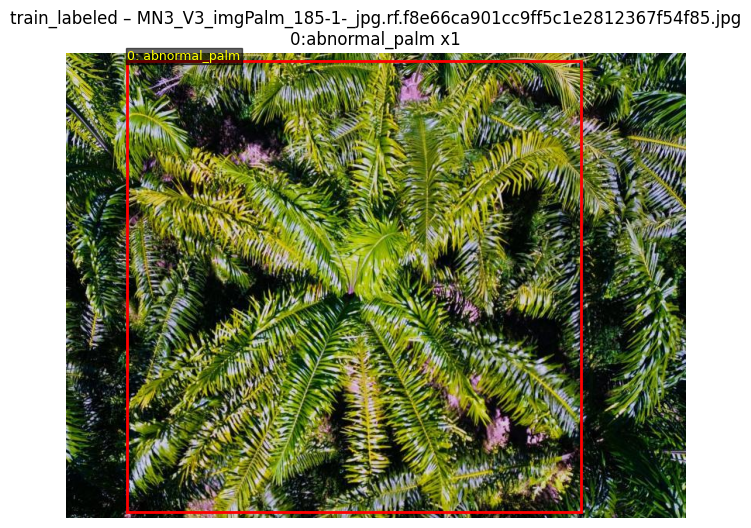


Image: MN3_V3_imgPalm_185-1-_jpg.rf.f8e66ca901cc9ff5c1e2812367f54f85.jpg
  class 0 (abnormal_palm): 1 boxes


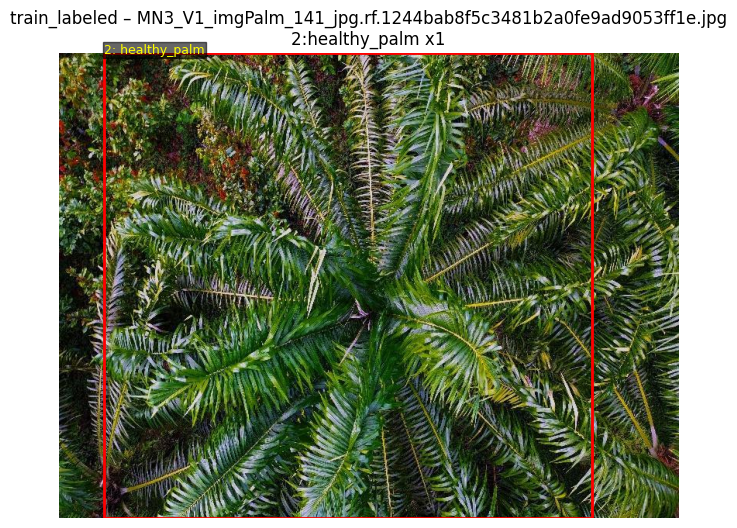


Image: MN3_V1_imgPalm_141_jpg.rf.1244bab8f5c3481b2a0fe9ad9053ff1e.jpg
  class 2 (healthy_palm): 1 boxes


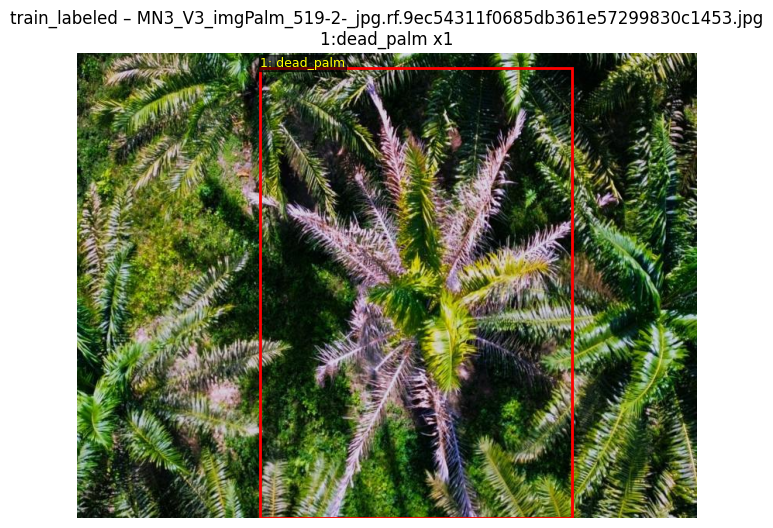


Image: MN3_V3_imgPalm_519-2-_jpg.rf.9ec54311f0685db361e57299830c1453.jpg
  class 1 (dead_palm): 1 boxes


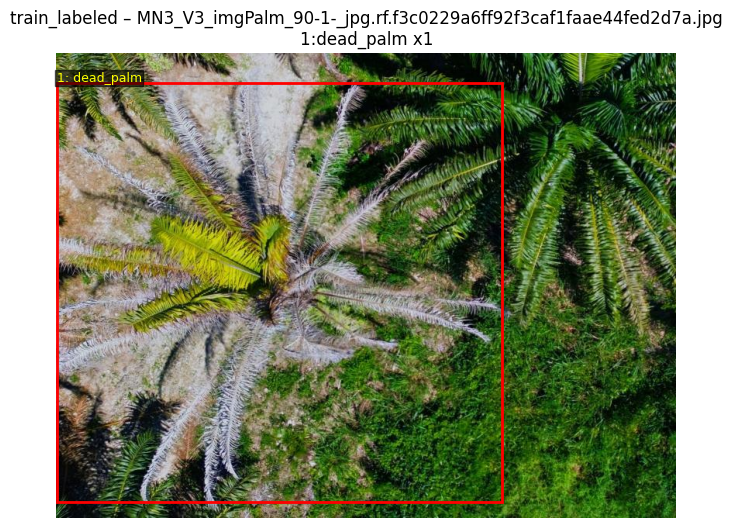


Image: MN3_V3_imgPalm_90-1-_jpg.rf.f3c0229a6ff92f3caf1faae44fed2d7a.jpg
  class 1 (dead_palm): 1 boxes


In [11]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter


# Quick visualization of bounding boxes 
BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
SSL_ROOT = WORK / "ssl_80_10_10"   


def load_yolo_labels(lbl_path):
  
    boxes = []
    with open(lbl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            cls = int(parts[0])
            x_c, y_c, w, h = map(float, parts[1:5])
            boxes.append({
                "cls": cls,
                "x_c": x_c,
                "y_c": y_c,
                "w":  w,
                "h":  h,
            })
    return boxes

def visualize_yolo_split(
    root,
    split="train_labeled",
    num_images=4,
    class_names=None,
    seed=42,
    figsize=(8, 8)
):
    """
    Draw YOLO bounding boxes on random images from a given split.
    
    root        : dataset root (e.g., SSL_ROOT)
    split       : "train_labeled", "val", or "test"
    num_images  : how many random images to show
    class_names : list of class names (same order as in 'names')
    """
    if class_names is None:
        class_names = []

    img_dir = Path(root) / split / "images"
    lbl_dir = Path(root) / split / "labels"

    if not img_dir.exists():
        raise FileNotFoundError(f"Image dir not found: {img_dir}")
    if not lbl_dir.exists():
        raise FileNotFoundError(f"Label dir not found (for labeled split): {lbl_dir}")

    # collect all images
    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(img_dir.glob(ext))

    if not img_paths:
        raise RuntimeError(f"No images found in {img_dir}")

    random.seed(seed)
    random.shuffle(img_paths)
    img_paths = img_paths[:num_images]

    for img_path in img_paths:
        stem = img_path.stem
        lbl_path = lbl_dir / f"{stem}.txt"

        if not lbl_path.exists():
            print(f"[WARN] No label file for {img_path.name}, skipping.")
            continue

        # load image
        img = plt.imread(img_path)
        h, w = img.shape[:2]

        # load YOLO boxes
        boxes = load_yolo_labels(lbl_path)

        # count classes in this image
        per_image_counts = Counter(b["cls"] for b in boxes)

        # plot
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(img)
        ax.axis("off")

        # make a small summary string for this image
        summary_parts = []
        for cls_id in sorted(per_image_counts.keys()):
            if 0 <= cls_id < len(class_names):
                cname = class_names[cls_id]
            else:
                cname = f"cls_{cls_id}"
            summary_parts.append(f"{cls_id}:{cname} x{per_image_counts[cls_id]}")
        summary_str = " | ".join(summary_parts) if summary_parts else "no boxes"

        ax.set_title(f"{split} – {img_path.name}\n{summary_str}")

        for b in boxes:
            cls = b["cls"]
            x_c, y_c, bw, bh = b["x_c"], b["y_c"], b["w"], b["h"]

            # convert normalized center coords to pixel top-left + width/height
            box_w = bw * w
            box_h = bh * h
            x_min = (x_c - bw / 2) * w
            y_min = (y_c - bh / 2) * h

            # rectangle
            rect = patches.Rectangle(
                (x_min, y_min),
                box_w,
                box_h,
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

            # label text: "id: name"
            if 0 <= cls < len(class_names):
                cls_name = class_names[cls]
            else:
                cls_name = f"cls_{cls}"

            text_str = f"{cls}: {cls_name}"

            ax.text(
                x_min,
                max(y_min - 2, 0),
                text_str,
                fontsize=9,
                color="yellow",
                bbox=dict(facecolor="black", alpha=0.6, pad=1),
            )

        plt.show()

        # also print counts in console for quick check
        print(f"\nImage: {img_path.name}")
        if per_image_counts:
            for cid in sorted(per_image_counts.keys()):
                cname = class_names[cid] if 0 <= cid < len(class_names) else f"cls_{cid}"
                print(f"  class {cid} ({cname}): {per_image_counts[cid]} boxes")
        else:
            print("  No boxes.")




# Visualize a few labeled training images 
visualize_yolo_split(
    root=SSL_ROOT,
    split="train_labeled",
    num_images=4,
    class_names=names,   
    seed=0
)


 # Train the Teacher (20% labeled only)

In [12]:
from pathlib import Path
import torch
from ultralytics import YOLO



BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"

# YAML with 20% labeled train split
TEACHER_DATA_YAML = WORK / "plam_ssl_labeled.yaml"


local_teacher_weights = WORK / "yolo12s.pt"
if local_teacher_weights.exists():
    TEACHER_INIT_WEIGHTS = str(local_teacher_weights)
else:
    TEACHER_INIT_WEIGHTS = "yolo12s.pt" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Teacher data yaml:", TEACHER_DATA_YAML)
print("Teacher init weights:", TEACHER_INIT_WEIGHTS)


teacher = YOLO(TEACHER_INIT_WEIGHTS)
teacher.to(device)

teacher_run_name = "teacher_yolov12s_20pct_labeled"

teacher.train(
    data=str(TEACHER_DATA_YAML),
    epochs=100,          
    imgsz=640,
    batch=8,  
    patience=10, 
    project=str(WORK / "runs_teacher"),
    name=teacher_run_name,
    workers=2,
    save=True,
    exist_ok=True,      
)


TEACHER_WEIGHTS_BEST = Path(teacher.ckpt_path)

print("\n✓ Teacher training finished.")
print("Best teacher weights saved at:", TEACHER_WEIGHTS_BEST)


Device: cuda
Teacher data yaml: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_labeled.yaml
Teacher init weights: yolo12s.pt
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_labeled.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_yolov12s_20pct_labeled, nbs=64, nms=False, opset

invalid value encountered in less
invalid value encountered in less


                   all        385       1032      0.916      0.901      0.956      0.716
         abnormal_palm        204        283      0.868      0.848       0.93      0.708
             dead_palm        199        225      0.995      0.967      0.988      0.768
          healthy_palm        222        524      0.884      0.887       0.95      0.674
Speed: 0.1ms preprocess, 6.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/palm_soft_teacher_yolov12n/runs_teacher/teacher_yolov12s_20pct_labeled

✓ Teacher training finished.
Best teacher weights saved at: yolo12s.pt


# Teacher training curves (20% labeled)

Loading teacher results from: /kaggle/working/palm_soft_teacher_yolov12n/runs_teacher/teacher_yolov12s_20pct_labeled/results.csv


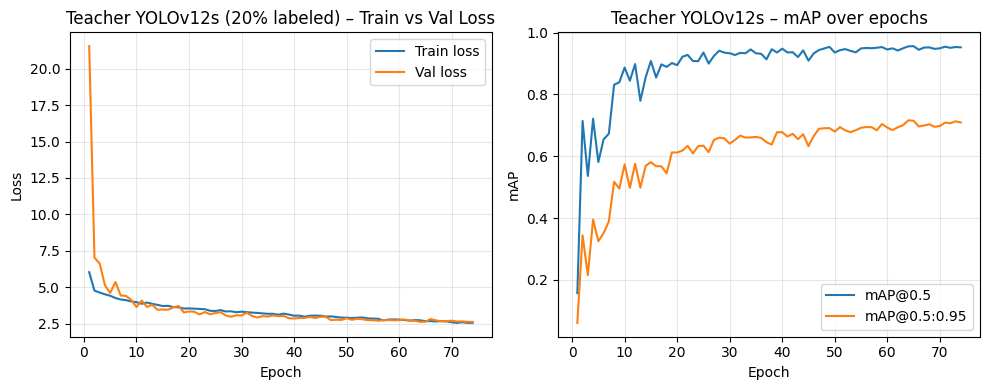

In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt



BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"


ssl_labeled_project = WORK / "runs_teacher"
ssl_labeled_name    = "teacher_yolov12s_20pct_labeled" 

run_dir = Path(ssl_labeled_project) / ssl_labeled_name
csv_path = run_dir / "results.csv"

print("Loading teacher results from:", csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"results.csv not found at {csv_path}")

df_teacher = pd.read_csv(csv_path)

# Epochs
epochs = df_teacher["epoch"] if "epoch" in df_teacher.columns else range(len(df_teacher))


train_loss_t = df_teacher["train/box_loss"] + df_teacher["train/cls_loss"]
if "train/dfl_loss" in df_teacher.columns:
    train_loss_t = train_loss_t + df_teacher["train/dfl_loss"]


val_loss_t = None
if {"val/box_loss", "val/cls_loss"}.issubset(df_teacher.columns):
    val_loss_t = df_teacher["val/box_loss"] + df_teacher["val/cls_loss"]
    if "val/dfl_loss" in df_teacher.columns:
        val_loss_t = val_loss_t + df_teacher["val/dfl_loss"]

#Metrics (mAP)
map50_t   = df_teacher["metrics/mAP50(B)"]      if "metrics/mAP50(B)" in df_teacher.columns else None
map5095_t = df_teacher["metrics/mAP50-95(B)"]   if "metrics/mAP50-95(B)" in df_teacher.columns else None

plt.figure(figsize=(10, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_t, label="Train loss")
if val_loss_t is not None:
    plt.plot(epochs, val_loss_t, label="Val loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Teacher YOLOv12s (20% labeled) – Train vs Val Loss")
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
has_any_map = False
if map50_t is not None:
    plt.plot(epochs, map50_t, label="mAP@0.5")
    has_any_map = True
if map5095_t is not None:
    plt.plot(epochs, map5095_t, label="mAP@0.5:0.95")
    has_any_map = True

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Teacher YOLOv12s – mAP over epochs")
if has_any_map:
    plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Generate pseudo-labels with the teacher

In [14]:
from pathlib import Path
import shutil
from ultralytics import YOLO


# Generate pseudo-labels with the teacher
BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
SSL_ROOT = WORK / "ssl_80_10_10"

UNLABELED_IMGS = SSL_ROOT / "train_unlabeled" / "images"
PSEUDO_DIR     = SSL_ROOT / "pseudo"
PSEUDO_IMGS    = PSEUDO_DIR / "images"
PSEUDO_LABEL   = PSEUDO_DIR / "labels"

PSEUDO_DIR.mkdir(parents=True, exist_ok=True)
PSEUDO_IMGS.mkdir(parents=True, exist_ok=True)
PSEUDO_LABEL.mkdir(parents=True, exist_ok=True)


teacher_run_name = "teacher_yolov12s_20pct_labeled"  
run_dir = WORK / "runs_teacher" / teacher_run_name

candidate_weights = [
    run_dir / "weights" / "best.pt",
    run_dir / "weights" / "last.pt",
]

TEACHER_WEIGHTS_BEST = None
for w in candidate_weights:
    if w.exists():
        TEACHER_WEIGHTS_BEST = w
        break

if TEACHER_WEIGHTS_BEST is None:
    raise FileNotFoundError(f"Could not find best/last teacher weights under {run_dir/'weights'}")

teacher = YOLO(str(TEACHER_WEIGHTS_BEST))


img_count = 0
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
    for img_path in UNLABELED_IMGS.glob(ext):
        dst = PSEUDO_IMGS / img_path.name
        if not dst.exists():
            shutil.copy(img_path, dst)
        img_count += 1


pred_subdir = PSEUDO_DIR / "preds"  

results = teacher.predict(
    source=str(PSEUDO_IMGS),
    conf=0.6,        
    iou=0.5,
    save_txt=True,     
    save_conf=True,
    save=False,        
    project=str(PSEUDO_DIR),
    name="preds",
    exist_ok=True,
    verbose=False,
)

pred_labels_dir = pred_subdir / "labels"
if not pred_labels_dir.exists():
    raise FileNotFoundError(f"Predicted labels folder not found: {pred_labels_dir}")

pseudo_label_count = 0
for txt in pred_labels_dir.glob("*.txt"):
    dst = PSEUDO_LABEL / txt.name
    shutil.copy(txt, dst)
    pseudo_label_count += 1


print(f"Unlabeled images: {img_count}")
print(f"Pseudo-labels written to: {pseudo_label_count} files in {PSEUDO_LABEL}")


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/preds
2446 labels saved to /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/preds/labels
Unlabeled images: 2468
Pseudo-labels written to: 2446 files in /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/labels


# Build the student training set (labeled + pseudo-labeled)

In [15]:
from pathlib import Path
import glob


BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
SSL_ROOT = WORK / "ssl_80_10_10"

train_labeled_img_dir  = SSL_ROOT / "train_labeled" / "images"
train_labeled_lbl_dir  = SSL_ROOT / "train_labeled" / "labels"
pseudo_img_dir         = SSL_ROOT / "pseudo" / "images"
pseudo_lbl_dir         = SSL_ROOT / "pseudo" / "labels"

student_yaml = WORK / "plam_ssl_student.yaml"

print("Student YAML:", student_yaml)
if not student_yaml.exists():
    print("[WARN] plam_ssl_student.yaml not found – you may need to run the YAML config cell first.")


def collect_images(img_dir):
    paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        paths.extend(img_dir.glob(ext))
    return sorted(paths)


student_labeled_imgs = collect_images(train_labeled_img_dir)
student_labeled_stems = [p.stem for p in student_labeled_imgs]

labeled_label_files = list(train_labeled_lbl_dir.glob("*.txt"))
labeled_label_stems = {p.stem for p in labeled_label_files}


labeled_imgs_with_labels = [
    p for p in student_labeled_imgs if p.stem in labeled_label_stems
]


student_pseudo_imgs = collect_images(pseudo_img_dir)
student_pseudo_stems = [p.stem for p in student_pseudo_imgs]

pseudo_label_files = list(pseudo_lbl_dir.glob("*.txt"))
pseudo_label_stems = {p.stem for p in pseudo_label_files}

pseudo_imgs_with_labels = [
    p for p in student_pseudo_imgs if p.stem in pseudo_label_stems
]


num_labeled_imgs        = len(student_labeled_imgs)
num_labeled_with_labels = len(labeled_imgs_with_labels)

num_pseudo_imgs         = len(student_pseudo_imgs)
num_pseudo_with_labels  = len(pseudo_imgs_with_labels)

total_student_imgs      = num_labeled_imgs + num_pseudo_imgs

print("\nStudent training set:")
print(f"  Labeled images        : {num_labeled_imgs}  (with labels: {num_labeled_with_labels})")
print(f"  Pseudo images         : {num_pseudo_imgs}  (with labels: {num_pseudo_with_labels})")
print(f"  Total train images    : {total_student_imgs}")

print("\nFolders used:")
print(f"  Labeled images dir    : {train_labeled_img_dir}")
print(f"  Labeled labels dir    : {train_labeled_lbl_dir}")
print(f"  Pseudo images dir     : {pseudo_img_dir}")
print(f"  Pseudo labels dir     : {pseudo_lbl_dir}")


Student YAML: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_student.yaml

Student training set:
  Labeled images        : 616  (with labels: 616)
  Pseudo images         : 2468  (with labels: 2446)
  Total train images    : 3084

Folders used:
  Labeled images dir    : /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/train_labeled/images
  Labeled labels dir    : /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/train_labeled/labels
  Pseudo images dir     : /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/images
  Pseudo labels dir     : /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/labels


# Train the SSL student (labeled + pseudo-labeled)

In [16]:
from pathlib import Path
import torch
from ultralytics import YOLO


BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
SSL_ROOT = WORK / "ssl_80_10_10"

PSEUDO_LABEL_DIR = SSL_ROOT / "pseudo" / "labels"
STUDENT_DATA_YAML = WORK / "plam_ssl_student.yaml"


if not PSEUDO_LABEL_DIR.exists():
    raise FileNotFoundError(f"Pseudo label directory not found: {PSEUDO_LABEL_DIR}")

fixed_files = 0
skipped_lines = 0

for txt in PSEUDO_LABEL_DIR.glob("*.txt"):
    lines_out = []
    with open(txt, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            if len(parts) < 5:
                # broken line, skip
                skipped_lines += 1
                continue
            # keep only first 5 columns: cls, x, y, w, h
            parts5 = parts[:5]
            lines_out.append(" ".join(parts5) + "\n")

    with open(txt, "w") as f:
        f.writelines(lines_out)
    fixed_files += 1

print(f"Fixed pseudo-label files: {fixed_files}")
print(f"Skipped weird/short lines: {skipped_lines}")
print(f"Pseudo-label folder (now 5-column YOLO format): {PSEUDO_LABEL_DIR}")


if not STUDENT_DATA_YAML.exists():
    raise FileNotFoundError(f"Student YAML not found: {STUDENT_DATA_YAML}")


weight_candidates = [
    WORK / "yolov12n.pt",
    WORK / "yolov12s.pt",
    WORK / "yolo12s.pt", 
]

STUDENT_INIT_WEIGHTS = None
for w in weight_candidates:
    if w.exists():
        STUDENT_INIT_WEIGHTS = str(w)
        break

if STUDENT_INIT_WEIGHTS is None:
   
    STUDENT_INIT_WEIGHTS = "yolo12s.pt" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print("\nDevice:", device)
print("Student data yaml:", STUDENT_DATA_YAML)
print("Student init weights:", STUDENT_INIT_WEIGHTS)


student = YOLO(STUDENT_INIT_WEIGHTS)
student.to(device)

student_run_name = "student_yolov12n_ssl_labeled_plus_pseudo"

student.train(
    data=str(STUDENT_DATA_YAML),
    epochs=100,               # max epochs
    patience=10,            
    imgsz=640,
    batch=8,                  # adjust for GPU memory
    project=str(WORK / "runs_student"),
    name=student_run_name,
    workers=2,
    save=True,
    exist_ok=True,            # allow rerun without error
)

STUDENT_WEIGHTS_BEST = Path(student.ckpt_path)

print("\n✓ Student training finished.")
print("Best student weights saved at:", STUDENT_WEIGHTS_BEST)


Fixed pseudo-label files: 2446
Skipped weird/short lines: 0
Pseudo-label folder (now 5-column YOLO format): /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/pseudo/labels

Device: cuda
Student data yaml: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_student.yaml
Student init weights: yolo12s.pt
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_student.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.0

invalid value encountered in less
invalid value encountered in less


                   all        385       1032      0.897      0.873      0.938      0.713
         abnormal_palm        204        283      0.875      0.753       0.89      0.686
             dead_palm        199        225      0.977      0.946       0.99      0.789
          healthy_palm        222        524       0.84      0.921      0.933      0.664
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/palm_soft_teacher_yolov12n/runs_student/student_yolov12n_ssl_labeled_plus_pseudo

✓ Student training finished.
Best student weights saved at: yolo12s.pt


# SSL student training curves

Loading SSL student results from: /kaggle/working/palm_soft_teacher_yolov12n/runs_student/student_yolov12n_ssl_labeled_plus_pseudo/results.csv


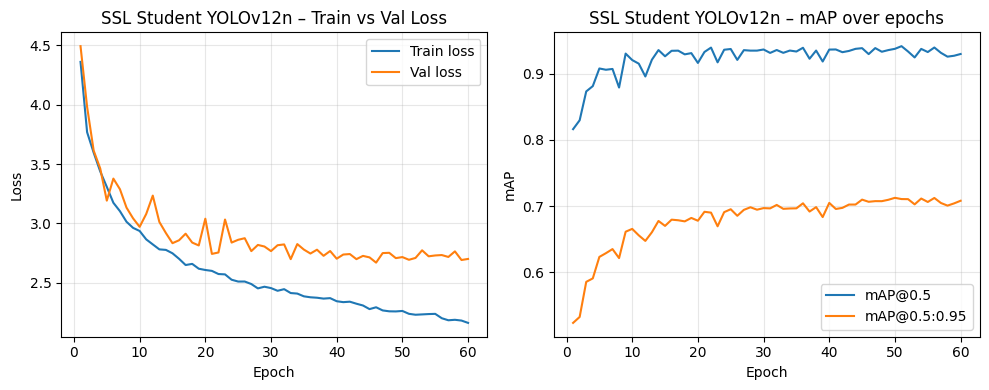

In [17]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"


ssl_student_project = WORK / "runs_student"
ssl_student_name    = "student_yolov12n_ssl_labeled_plus_pseudo"

run_dir = Path(ssl_student_project) / ssl_student_name
csv_path = run_dir / "results.csv"

print("Loading SSL student results from:", csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"results.csv not found at {csv_path}")

df_student = pd.read_csv(csv_path)

# Epochs
epochs = df_student["epoch"] if "epoch" in df_student.columns else range(len(df_student))

#  Total train loss = box + cls
train_loss_s = df_student["train/box_loss"] + df_student["train/cls_loss"]
if "train/dfl_loss" in df_student.columns:
    train_loss_s = train_loss_s + df_student["train/dfl_loss"]

#  Total val loss 
val_loss_s = None
if {"val/box_loss", "val/cls_loss"}.issubset(df_student.columns):
    val_loss_s = df_student["val/box_loss"] + df_student["val/cls_loss"]
    if "val/dfl_loss" in df_student.columns:
        val_loss_s = val_loss_s + df_student["val/dfl_loss"]

#  Metrics (mAP) 
map50_s   = df_student["metrics/mAP50(B)"]    if "metrics/mAP50(B)" in df_student.columns else None
map5095_s = df_student["metrics/mAP50-95(B)"] if "metrics/mAP50-95(B)" in df_student.columns else None

plt.figure(figsize=(10, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_s, label="Train loss")
if val_loss_s is not None:
    plt.plot(epochs, val_loss_s, label="Val loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SSL Student YOLOv12n – Train vs Val Loss")
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
has_any_map = False
if map50_s is not None:
    plt.plot(epochs, map50_s, label="mAP@0.5")
    has_any_map = True
if map5095_s is not None:
    plt.plot(epochs, map5095_s, label="mAP@0.5:0.95")
    has_any_map = True

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("SSL Student YOLOv12n – mAP over epochs")
if has_any_map:
    plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Evaluation on the test set

In [18]:
from pathlib import Path
import pandas as pd
from ultralytics import YOLO



BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"


TEST_DATA_YAML = WORK / "plam_ssl_labeled.yaml"
if not TEST_DATA_YAML.exists():
    raise FileNotFoundError(f"Test data yaml not found: {TEST_DATA_YAML}")

print("Test data yaml:", TEST_DATA_YAML)


baseline_project = WORK / "runs_baseline"
baseline_name    = "baseline_yolov12s_full"     

# Teacher (20% labeled) run
teacher_project  = WORK / "runs_teacher"
teacher_name     = "teacher_yolov12s_20pct_labeled"

# SSL Student run
student_project  = WORK / "runs_student"
student_name     = "student_yolov12n_ssl_labeled_plus_pseudo"


def get_best_weights(run_dir: Path):
    """Pick best.pt or last.pt from a YOLO run directory."""
    candidates = [
        run_dir / "weights" / "best.pt",
        run_dir / "weights" / "last.pt",
    ]
    for w in candidates:
        if w.exists():
            return w
    return None


def eval_model_on_ssl_test(run_dir: Path, label: str):
    """Load model from run_dir and evaluate on the SSL test split."""
    weights = get_best_weights(run_dir)
    if weights is None:
        print(f"[WARN] No best/last.pt found for {label} in {run_dir}")
        return None

    print(f"\n=== Evaluating {label} ===")
    print("Weights:", weights)

    model = YOLO(str(weights))
    res = model.val(
        data=str(TEST_DATA_YAML),
        split="test",     
        imgsz=640,
        batch=16,
        verbose=False,
    )

 
    box_metrics = res.box

    mAP50 = float(box_metrics.map50)          # mAP@0.5
    mAP5095 = float(box_metrics.map)         # mAP@0.5:0.95
    precision = float(box_metrics.p.mean())  # mean over classes
    recall = float(box_metrics.r.mean())

    print(f"{label} – mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP5095:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}")

    return {
        "model": label,
        "mAP@0.5": mAP50,
        "mAP@0.5:0.95": mAP5095,
        "precision": precision,
        "recall": recall,
    }



rows = []

# Baseline (full-supervised)
baseline_run_dir = baseline_project / baseline_name
if baseline_run_dir.exists():
    r = eval_model_on_ssl_test(baseline_run_dir, "Baseline full-supervised")
    if r is not None:
        rows.append(r)
else:
    print(f"[INFO] Baseline run dir not found: {baseline_run_dir} "
          f"(skip baseline, or adjust baseline_name).")

# Teacher
teacher_run_dir = teacher_project / teacher_name
if teacher_run_dir.exists():
    r = eval_model_on_ssl_test(teacher_run_dir, "Teacher (20% labeled)")
    if r is not None:
        rows.append(r)
else:
    print(f"[WARN] Teacher run dir not found: {teacher_run_dir}")

# SSL Student
student_run_dir = student_project / student_name
if student_run_dir.exists():
    r = eval_model_on_ssl_test(student_run_dir, "SSL Student (20% + pseudo)")
    if r is not None:
        rows.append(r)
else:
    print(f"[WARN] Student run dir not found: {student_run_dir}")


if rows:
    df_compare = pd.DataFrame(rows)
    df_compare = df_compare.set_index("model")
    print("\n Test-set comparison (SSL test split):")
    display(df_compare.style.format("{:.4f}"))
else:
    print("\n[ERROR] No evaluation rows collected. "
          "Check run directories and names.")


Test data yaml: /kaggle/working/palm_soft_teacher_yolov12n/plam_ssl_labeled.yaml
[INFO] Baseline run dir not found: /kaggle/working/palm_soft_teacher_yolov12n/runs_baseline/baseline_yolov12s_full (skip baseline, or adjust baseline_name).

=== Evaluating Teacher (20% labeled) ===
Weights: /kaggle/working/palm_soft_teacher_yolov12n/runs_teacher/teacher_yolov12s_20pct_labeled/weights/best.pt
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,232,041 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2382.0±863.9 MB/s, size: 139.6 KB)
val: Scanning /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/test/labels... 386 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 386/386 1.5Kit/s 0.3s
val: New cache created: /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP

invalid value encountered in less
invalid value encountered in less


                   all        386       1002      0.923      0.915      0.967       0.72
Speed: 1.3ms preprocess, 5.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Teacher (20% labeled) – mAP@0.5: 0.9669, mAP@0.5:0.95: 0.7200, Precision: 0.9231, Recall: 0.9155

=== Evaluating SSL Student (20% + pseudo) ===
Weights: /kaggle/working/palm_soft_teacher_yolov12n/runs_student/student_yolov12n_ssl_labeled_plus_pseudo/weights/best.pt
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,232,041 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1842.0±861.5 MB/s, size: 117.7 KB)
val: Scanning /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/test/labels.cache... 386 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 386/386 849.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50 

invalid value encountered in less
invalid value encountered in less


                   all        386       1002      0.911      0.896       0.95      0.715
Speed: 1.3ms preprocess, 5.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2
SSL Student (20% + pseudo) – mAP@0.5: 0.9501, mAP@0.5:0.95: 0.7151, Precision: 0.9108, Recall: 0.8959

 Test-set comparison (SSL test split):


 # Semi-Supervised performance table

In [19]:
import pandas as pd


try:
    df_compare
except NameError:
    raise RuntimeError(
        "df_compare is not defined. Run the evaluation cell first so df_compare is created."
    )

# Desired order of rows 
model_order = [
    "Baseline full-supervised",
    "Teacher (20% labeled)",
    "SSL Student (20% + pseudo)",
]

available_models = [m for m in model_order if m in df_compare.index]
if not available_models:
    raise RuntimeError(
        "No matching models found in df_compare. "
        "Check that the labels used in eval match those in model_order."
    )

df_ssl = df_compare.loc[available_models].copy()


supervision_map = {
    "Baseline full-supervised": "100% labeled",
    "Teacher (20% labeled)": "20% labeled only",
    "SSL Student (20% + pseudo)": "20% labeled + pseudo-labels",
}
df_ssl.insert(
    0,
    "Supervision",
    [supervision_map.get(m, "") for m in df_ssl.index],
)

# Nice formatting
df_ssl_rounded = df_ssl.copy()
for col in ["mAP@0.5", "mAP@0.5:0.95", "precision", "recall"]:
    if col in df_ssl_rounded.columns:
        df_ssl_rounded[col] = df_ssl_rounded[col].map(lambda x: f"{x:.4f}")

print("🧾 Semi-Supervised performance table (SSL test split):")
display(df_ssl_rounded)


🧾 Semi-Supervised performance table (SSL test split):


Supervision mAP@0.5 mAP@0.5:0.95  \
model                                                                          
Teacher (20% labeled)                  20% labeled only  0.9669       0.7200   
SSL Student (20% + pseudo)  20% labeled + pseudo-labels  0.9501       0.7151   

                           precision  recall  
model                                         
Teacher (20% labeled)         0.9231  0.9155  
SSL Student (20% + pseudo)    0.9108  0.8959

 # Qualitative predictions 

Model: SSL Student (20% + pseudo)
Weights: /kaggle/working/palm_soft_teacher_yolov12n/runs_student/student_yolov12n_ssl_labeled_plus_pseudo/weights/best.pt
Test images dir: /kaggle/working/palm_soft_teacher_yolov12n/ssl_80_10_10/test/images
Confidence threshold: 0.4



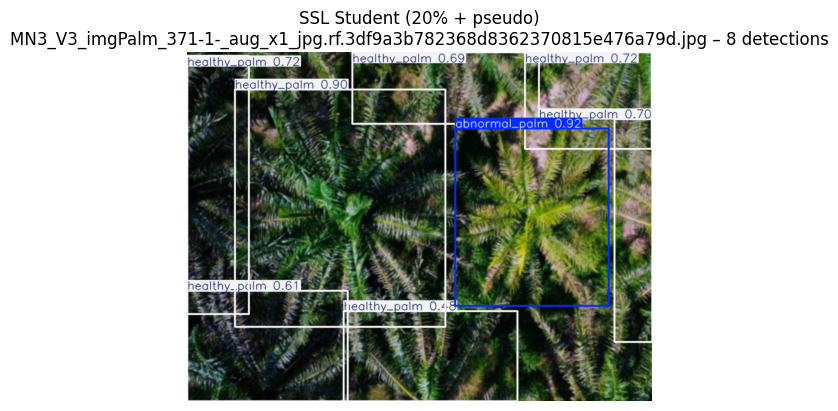

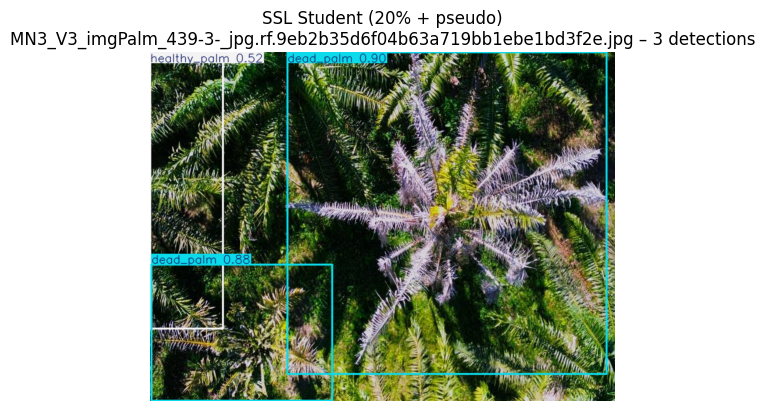

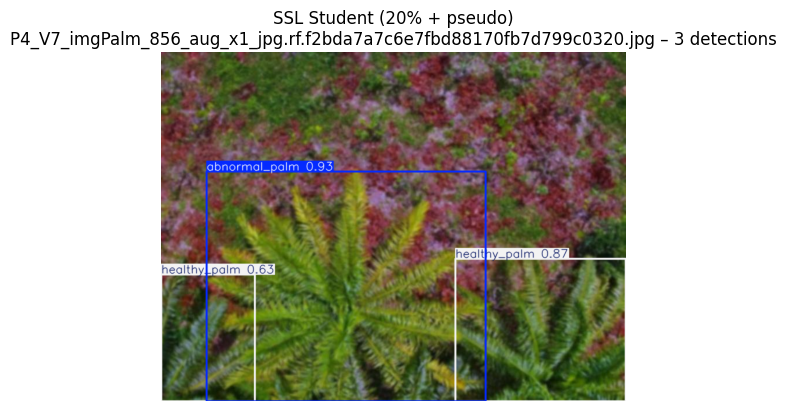

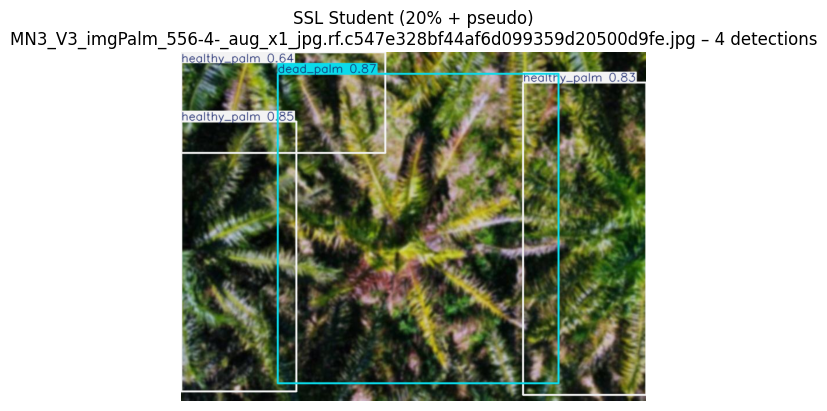

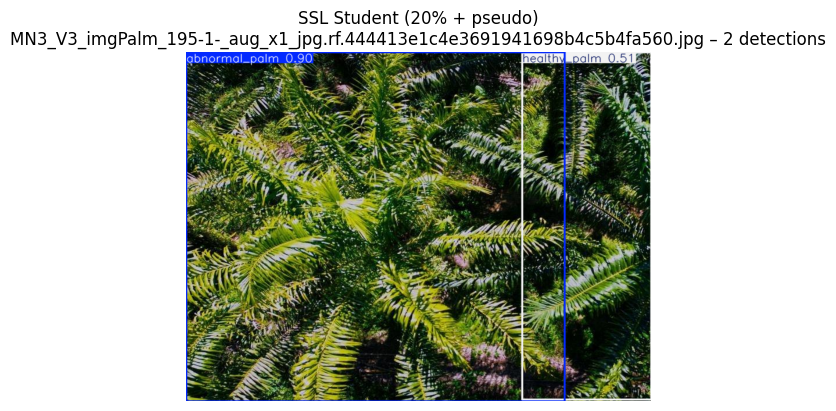

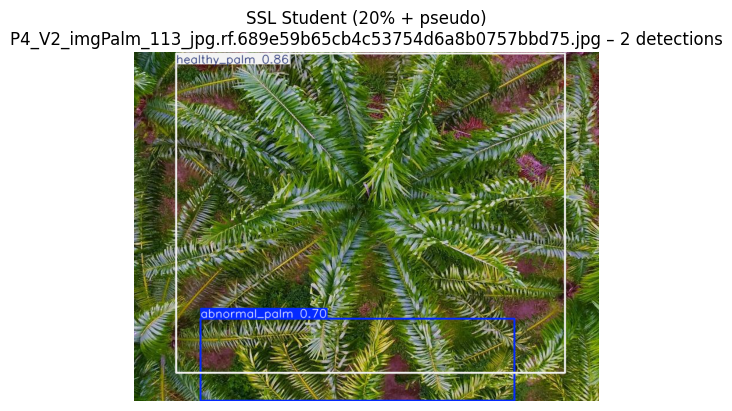

In [20]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO


# Qualitative predictions 
BASE = Path("/kaggle/working")
WORK = BASE / "palm_soft_teacher_yolov12n"
SSL_ROOT = WORK / "ssl_80_10_10"

TEST_IMG_DIR = SSL_ROOT / "test" / "images"
baseline_project = WORK / "runs_baseline"
baseline_name    = "baseline_yolov12s_full"            
teacher_project  = WORK / "runs_teacher"
teacher_name     = "teacher_yolov12s_20pct_labeled"

student_project  = WORK / "runs_student"
student_name     = "student_yolov12n_ssl_labeled_plus_pseudo"


def get_best_weights(run_dir: Path):
    """Pick best.pt or last.pt from a YOLO run directory."""
    candidates = [
        run_dir / "weights" / "best.pt",
        run_dir / "weights" / "last.pt",
    ]
    for w in candidates:
        if w.exists():
            return w
    return None


def qualitative_predictions(
    model_kind="student",   # "baseline", "teacher", or "student"
    num_images=6,
    conf=0.4,
    seed=0,
    imgsz=640,
):
    """
    Show qualitative predictions for a given model on random test images.
    model_kind: "baseline", "teacher", or "student"
    """

    model_kind = model_kind.lower()
    if model_kind == "baseline":
        run_dir = baseline_project / baseline_name
        nice_name = "Baseline full-supervised"
    elif model_kind == "teacher":
        run_dir = teacher_project / teacher_name
        nice_name = "Teacher (20% labeled)"
    elif model_kind == "student":
        run_dir = student_project / student_name
        nice_name = "SSL Student (20% + pseudo)"
    else:
        raise ValueError("model_kind must be one of: 'baseline', 'teacher', 'student'")

    if not run_dir.exists():
        raise FileNotFoundError(f"Run directory not found for {nice_name}: {run_dir}")

    weights = get_best_weights(run_dir)
    if weights is None:
        raise FileNotFoundError(f"No best/last.pt found under {run_dir/'weights'}")

    print(f"Model: {nice_name}")
    print(f"Weights: {weights}")
    print(f"Test images dir: {TEST_IMG_DIR}")
    print(f"Confidence threshold: {conf}\n")

    model = YOLO(str(weights))

    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(TEST_IMG_DIR.glob(ext))

    if not img_paths:
        raise RuntimeError(f"No images found in test dir: {TEST_IMG_DIR}")

    random.seed(seed)
    random.shuffle(img_paths)
    img_paths = img_paths[:num_images]

   
    results = model.predict(
        source=[str(p) for p in img_paths],
        conf=conf,
        imgsz=imgsz,
        verbose=False,
    )

    # Plot predictions
    for img_path, res in zip(img_paths, results):
       
        plotted = res.plot()          
        if plotted.shape[-1] == 3:  
            plotted = plotted[..., ::-1]

        # Build a short metrics string per image (number of boxes)
        n_boxes = len(res.boxes) if hasattr(res, "boxes") else 0
        img_title = f"{nice_name}\n{img_path.name} – {n_boxes} detections"

        plt.figure(figsize=(6, 6))
        plt.imshow(plotted)
        plt.axis("off")
        plt.title(img_title)
        plt.show()




# SSL student qualitative predictions on test images
qualitative_predictions(
    model_kind="student",   
    num_images=6,
    conf=0.4,
    seed=0,
    imgsz=640,
)


